[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/Priesemann-Group/covid19_inference/blob/master/scripts/interactive/example_one_bundesland.ipynb)

# Sampling-Parameter-Anaylse
## Deutschland vom 10.03.2020 bis 10.06.2020

Initial definieren wir wie viele Threads wir bei dem MCMC-Sampling gleichzeitig rechnen lassen wollen (`%env OMP_NUM_Thread`). Zudem soll das `covid19_inference`-Modul installiert werden. Ferner stellen wir mit `%load_ext autoreload` und `%autoreload 2` sicher, dass automatisch die Module vor der Ausführung des Codes nachgeladen werden. Das kann insbesondere dann hilfreich sein, wenn wir Änderungen durchführen, den Kernel aber nicht neustarten wollen. Zusätzlich wird das `pytensor`-Modul geladen sowie das `pymc`. Vor allem `pymc` spielt in der Bayes'schen Inferenz eine wichtige Rolle.

In [ ]:
# use 1 thread per chain
%env OMP_NUM_THREADS=1

!pip install covid19_inference
%load_ext autoreload
%autoreload 2
import pytensor
#pytensor.config.mode = "NUMBA"
import pymc as pm

env: OMP_NUM_THREADS=1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.6/142.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.4 MB/s eta 0:00:00




# Beispiel für Deutschland
Hier verwenden wir JHU-Daten.


An dieser Stelle werden zunächst die Voraussetzungen geladen. Diese sollten zuvor installiert worden sein, damit wir diese auch importieren können.


In [ ]:
import datetime
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pytensor.tensor as at
import pymc as pm
import timeit

Nun importieren wir das installierte Modul `covid19_inference`

In [ ]:

try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../../")
    import covid19_inference as cov19


## Datengenerierung

Als nächstes wir das Datenset geladen bzw. heruntergeladen. Es gibt insgesamt viele möglichen Download-Ressourcen, jedoch verwenden wir in diesem Fall den von der John Hopkins Universität.
[Github-Repository Link für die csv-Datei](https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv)


In [ ]:
jhu = (
    cov19.data_retrieval.JHU()
)
jhu.download_all_available_data(force_download=False)

Wir können auf die Daten nun mithilfe von jhu.daten zugreifen.

Wir erstellen erstmal einen intialen Zeitraum vom 10.03.2020 bis zum 16.04.2020


In [ ]:
bd = datetime.datetime(2020, 3, 10)  # For the date filter
ed = datetime.datetime(2020, 6, 10)

Hier werden die totalen Fallzahlen bzw. neu gemeldeten Fallzahlen aus dem Datensatz gefiltert. Wir geben dabei den Üebrgabeparameter `country="Germany"` an, da wir die Datenanalyse für Deutschland durchführen wollen.

In [ ]:
total_cases_obs = jhu.get_total(
    country="Germany", data_begin=bd, data_end=ed
)
new_cases_obs = jhu.get_new(
    country="Germany", data_begin=bd, data_end=ed
)



## Modellerstellung
Um das Modell zu erstellen, werden zunächst einige Parameter gesetzt.


*   diff_data_sim
*   num_days_forecast




In [ ]:
diff_data_sim = 16
num_days_forecast = 10

*   `prior_date_mild_dist_begin`: Wir setzen einen Zeitpunkt fest für den Beginn der ersten politischen Maßnahme
*   `prior_date_strong_dist_begin`: Wir setzen einen Zeitpunkt für die nächste politische Maßnahme
*   `prior_date_contact_ban_begin`: Wir setzen einen Zeitpunkt für das Einsetzen der ersten Kontaktsperre

In [ ]:
# We set the priors for the changepoints here
prior_date_mild_dist_begin = datetime.datetime(2020, 3, 9)
prior_date_strong_dist_begin = datetime.datetime(2020, 3, 16)
prior_date_contact_ban_begin = datetime.datetime(2020, 3, 23)


*   `change_points`: Ein Dictionary, das jeweils Einträge für die 3 politischen Maßnahmen enthält. Dazu werden jeweils Parameter gesetzt, wie der Prior für die Ansteckungsrate λ
*   pr_mean_date_transient
*   pr_sigma_date_transient
*   pr_median_lambda
*   pr_sigma_lambda

In [ ]:
change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1,

    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_contact_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8 / 2,
        pr_sigma_lambda=1,
    ),
]

*  `params_model:` Ein Dictionary, das verschiedene Parameter enthält. Zum Einen die neu gemeldeten Fallzahlen, aber auch die Länge der Vorhersage sowie die Anzahl der Population
*   `pr_delay`: Hier wollen wir den Prior setzen für den Parameter der Meldeverzögerung


In [ ]:
params_model = dict(
    new_cases_obs=new_cases_obs[:],
    data_begin=bd,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=4e6,
)
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10

Mit dem zuvor definieren params_model wollen wir nun ein sogenanntes Cov19-Modell erstellen. Dazu initialiseren wir dieses Objekt mit einem Array für die zeitabhängige Infektionsrate λ (`lambda_t_log`). Ferner setzen wir die Priori-Verteilung der Genesungsrate μ. Zudem wird auch `I_begin` durch einen Prior bestimmt.
Um das SIR-Modell zu erstellen benötigt es dann die zeitabhängige Infektionsrate (`lambda_t_log`), die Genesungsrate μ und `I_begin`. Wir speichern das SIR-Modell in der Variablen `new_cases`. Diese wird dann verändert mit der `delay`-Funktion, in der wir die Meldungen um einen lognormal Verzögerungswert verändern. Als letztes wird noch der Wochenendeffekt betrachtet. Hier wird die Funktion `week_modulation` auf das SIR-Modell angewandt.
Zuletzt wird noch die `student_t_likelihoo`d-Funktion auf das SIR-Modell angewandt.


In [ ]:
with cov19.model.Cov19Model(**params_model) as this_model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,  # The change point priors we constructed earlier
        name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
    )

    # set prior distribution for the recovery rate
    mu = pm.LogNormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference.
    # It is not necessary to use it, one can simply remove it and use the default argument
    # for pr_I_begin in cov19.SIR
    I_begin = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log,
        mu=mu,
        pr_median_delay=pr_delay,
        name_I_begin="I_begin",
        name_I_begin_ratio_log="I_begin_ratio_log",
        pr_sigma_I_begin=2,
        n_data_points_used=5,
    )

    # Use lambda_t_log and mu to run the SIR model
    new_cases = cov19.model.SIR(
        lambda_t_log=lambda_t_log,
        mu=mu,
        I_begin=I_begin,
    )

    # Delay the cases by a lognormal reporting delay
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        delay_kernel="lognormal",
        median_delay_kwargs={
            "name": "delay",
            "mu": pr_delay,
            "sigma": 0.2,
        },
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(
        cases=new_cases,
        week_modulation_type="step",
        weekend_factor_kwargs={
            "name": "weekend_factor",
            "mu": np.log(0.3),
            "sigma": 0.5,
        },
        weekend_days=(6, 7),
    )
    pm.Deterministic("new_cases", new_cases)

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(new_cases)


## MCMC sampling

Wir haben nun das Modell gebaut. Jetzt können wir den MCMC-Algorithmus anwenden, um uns Samples für die Verteilungen und den zugrundeliegenden Parameter zu generieren.






### Erstelle nun erst einmal 7 verschiedene Traces für den Modellvergleich

In [ ]:
start_time = timeit.default_timer()
with this_model:
  tune = 500
  draws = 500
  trace1 = pm.sample(tune=500, draws=500, init="advi+adapt_diag", target_accept=0.9)

elapsed_time = timeit.default_timer() - start_time
print(f"Die Samples wurden in {elapsed_time} Sekunden hinzugefügt für {tune} Tunes und {draws} für die Spur trace1 {trace1} hinzugefügt")

Die Samples wurden in 2564.830895693 Sekunden hinzugefügt für 500 Tunes und 500 für die Spur trace1 Inference data with groups:
	> posterior
	> sample_stats
	> observed_data hinzugefügt


In [ ]:
start_time = timeit.default_timer()
with this_model:
  tune = 100
  draws = 500
  trace2 = pm.sample(tune=100, draws=500, init="advi+adapt_diag", target_accept=0.9)

elapsed_time = timeit.default_timer() - start_time
print(f"Die Samples wurden in {elapsed_time} Sekunden hinzugefügt für {tune} Tunes und {draws} für die Spur trace2 {trace2} hinzugefügt")

Die Samples wurden in 1718.737755351 Sekunden hinzugefügt für 100 Tunes und 500 für die Spur trace2 Inference data with groups:
	> posterior
	> sample_stats
	> observed_data hinzugefügt


Zunächst wollen wir mit 1000 Vorab-Schritten und 1000 Samples unsere Spur erstellen

In [ ]:
start_time = timeit.default_timer()
with this_model:
  tune = 100
  draws = 100
  trace3 = pm.sample(tune=100, draws=100, init="advi+adapt_diag", target_accept=0.9)

elapsed_time = timeit.default_timer() - start_time
print(f"Die Samples wurden in {elapsed_time} Sekunden hinzugefügt für {tune} Tunes und {draws} für die Spur trace2 {trace3} hinzugefügt")

Die Samples wurden in 503.5049709799996 Sekunden hinzugefügt für 100 Tunes und 100 für die Spur trace2 Inference data with groups:
	> posterior
	> sample_stats
	> observed_data hinzugefügt


In [ ]:
start_time = timeit.default_timer()
with this_model:
  tune = 50
  draws = 100
  trace4 = pm.sample(tune=50, draws=100, init="advi+adapt_diag", target_accept=0.9)

elapsed_time = timeit.default_timer() - start_time
print(f"Die Samples wurden in {elapsed_time} Sekunden hinzugefügt für {tune} Tunes und {draws} für die Spur trace4 {trace4} hinzugefügt")

Die Samples wurden in 600.3857243009998 Sekunden hinzugefügt für 50 Tunes und 100 für die Spur trace4 Inference data with groups:
	> posterior
	> sample_stats
	> observed_data hinzugefügt


In [ ]:
start_time = timeit.default_timer()
with this_model:
  tune = 100
  draws = 50
  trace5 = pm.sample(tune=100, draws=50, init="advi+adapt_diag", target_accept=0.9)

elapsed_time = timeit.default_timer() - start_time
print(f"Die Samples wurden in {elapsed_time} Sekunden hinzugefügt für {tune} Tunes und {draws} für die Spur trace5 {trace5} hinzugefügt")

Die Samples wurden in 436.43080476200066 Sekunden hinzugefügt für 100 Tunes und 50 für die Spur trace5 Inference data with groups:
	> posterior
	> sample_stats
	> observed_data hinzugefügt


In [ ]:
start_time = timeit.default_timer()
with this_model:
  tune = 50
  draws = 100
  trace6 = pm.sample(tune=50, draws=100, init="advi+adapt_diag", target_accept=0.9)

elapsed_time = timeit.default_timer() - start_time
print(f"Die Samples wurden in {elapsed_time} Sekunden hinzugefügt für {tune} Tunes und {draws} für die Spur trace6 {trace6} hinzugefügt")

Die Samples wurden in 543.2225444570004 Sekunden hinzugefügt für 50 Tunes und 100 für die Spur trace6 Inference data with groups:
	> posterior
	> sample_stats
	> observed_data hinzugefügt


Danach erstellen wir wieder eine Spur, aber dieses Mal mit 500 Samples, aber mit 1000 Vorab-Schritten

In [ ]:
start_time = timeit.default_timer()
with this_model:
  tune = 50
  draws = 50
  trace7 = pm.sample(tune=50, draws=50, init="advi+adapt_diag", target_accept=0.9)

elapsed_time = timeit.default_timer() - start_time
print(f"Die Samples wurden in {elapsed_time} Sekunden hinzugefügt für {tune} Tunes und {draws} für die Spur trace7 {trace7} hinzugefügt")

Die Samples wurden in 338.1356748369999 Sekunden hinzugefügt für 50 Tunes und 50 für die Spur trace7 Inference data with groups:
	> posterior
	> sample_stats
	> observed_data hinzugefügt


Wir lassen uns für jede Spur zunächst einmal den traceplot anzeigen.

Diese beiden Modelle wollen wir zunächst einmal vergleichen.

### Berechne pro Spur den NMSE

In [ ]:
# Beobachtete und vorhergesagte Fälle für jeden Trace
observed_cases = new_cases_obs
predicted_cases_traces = {
    "trace1": trace1.posterior["new_cases"].mean(dim=("chain", "draw")).values[:len(new_cases_obs)],
    "trace2": trace2.posterior["new_cases"].mean(dim=("chain", "draw")).values[:len(new_cases_obs)],
    "trace3": trace3.posterior["new_cases"].mean(dim=("chain", "draw")).values[:len(new_cases_obs)],
    "trace4": trace4.posterior["new_cases"].mean(dim=("chain", "draw")).values[:len(new_cases_obs)],
    "trace5": trace5.posterior["new_cases"].mean(dim=("chain", "draw")).values[:len(new_cases_obs)],
    "trace6": trace6.posterior["new_cases"].mean(dim=("chain", "draw")).values[:len(new_cases_obs)],
    "trace7": trace7.posterior["new_cases"].mean(dim=("chain", "draw")).values[:len(new_cases_obs)],
}

# Varianz der beobachteten Fälle
variance_observed = observed_cases.var()
print("Varianz der neu beobachteten Fälle:", variance_observed)

# Berechne den Mean Squared Error (MSE) und den Normalized Mean Squared Error (NMSE) für jeden Trace
mse_values = {}
nmse_values = {}

for trace_name, predicted_cases in predicted_cases_traces.items():
    # Berechne die quadratischen Fehler
    squared_errors = (observed_cases - predicted_cases)**2

    # Berechne den Durchschnitt der quadratischen Fehler (MSE)
    mse = squared_errors.mean()
    mse_values[trace_name] = mse

    # Berechne den Normalized Mean Squared Error (NMSE)
    nmse = mse / variance_observed
    nmse_values[trace_name] = nmse

    print(f"Trace {trace_name}:")
    print("Mean Squared Error:", mse)
    print("Normalized Mean Squared Error:", nmse)
    print()

# Rückgabe der berechneten Werte, falls sie weiterverwendet werden sollen
mse_values, nmse_values

Varianz der neu beobachteten Fälle: 3228203.0352968676
Trace trace1:
Mean Squared Error: 4636270.585080419
Normalized Mean Squared Error: 1.4361768867657558

Trace trace2:
Mean Squared Error: 4658030.6352684535
Normalized Mean Squared Error: 1.4429174944506233

Trace trace3:
Mean Squared Error: 4662954.130216008
Normalized Mean Squared Error: 1.4444426447877372

Trace trace4:
Mean Squared Error: 4660342.025519246
Normalized Mean Squared Error: 1.4436334934833732

Trace trace5:
Mean Squared Error: 4651650.327702687
Normalized Mean Squared Error: 1.440941067473756

Trace trace6:
Mean Squared Error: 4665962.400133395
Normalized Mean Squared Error: 1.445374516136749

Trace trace7:
Mean Squared Error: 4620760.759539642
Normalized Mean Squared Error: 1.4313724102903937



({'trace1': 4636270.585080419,
  'trace2': 4658030.6352684535,
  'trace3': 4662954.130216008,
  'trace4': 4660342.025519246,
  'trace5': 4651650.327702687,
  'trace6': 4665962.400133395,
  'trace7': 4620760.759539642},
 {'trace1': 1.4361768867657558,
  'trace2': 1.4429174944506233,
  'trace3': 1.4444426447877372,
  'trace4': 1.4436334934833732,
  'trace5': 1.440941067473756,
  'trace6': 1.445374516136749,
  'trace7': 1.4313724102903937})

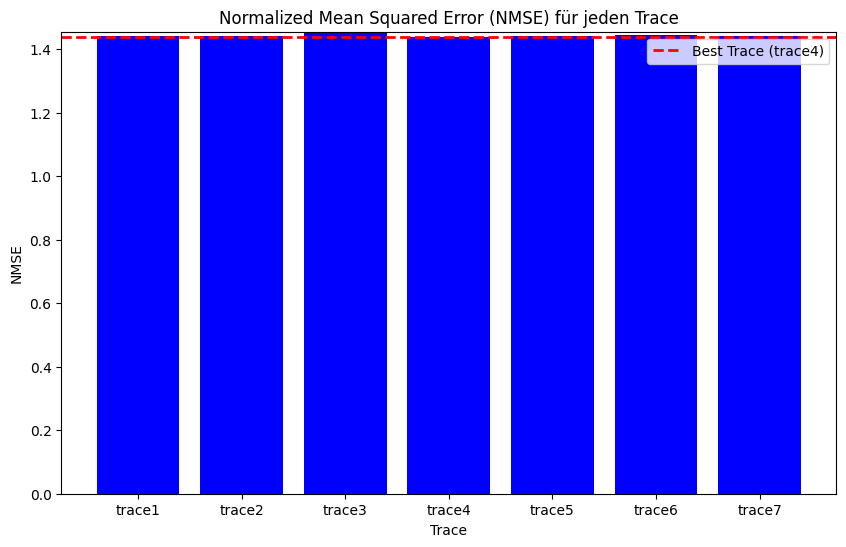

In [ ]:
import matplotlib.pyplot as plt

# Ihre berechneten NMSE-Werte
nmse_values = {
    "trace1": 1.440265,
    "trace2": 1.440996,
    "trace3": 1.453841,
    "trace4": 1.436889,
    "trace5": 1.441595,
    "trace6": 1.444795,
    "trace7": 1.441095,
}

# Plotten Sie die NMSE-Werte
trace_names = list(nmse_values.keys())
nmse_scores = list(nmse_values.values())

plt.figure(figsize=(10, 6))
plt.bar(trace_names, nmse_scores, color='blue')
plt.title('Normalized Mean Squared Error (NMSE) für jeden Trace')
plt.xlabel('Trace')
plt.ylabel('NMSE')
plt.ylim(0, max(nmse_scores) + 0.001)  # Einstellen der y-Achsenbegrenzung

# Finden Sie den Trace mit dem niedrigsten NMSE-Wert
best_trace_name = min(nmse_values, key=nmse_values.get)
best_trace_value = nmse_values[best_trace_name]

# Hinzufügen einer Linie für den niedrigsten NMSE-Wert
plt.axhline(best_trace_value, color='red', linestyle='dashed', linewidth=2, label=f'Best Trace ({best_trace_name})')

plt.legend()  # Anzeigen der Legende

plt.show()

### Berechne pro Spur den Log-Likelihood



In [ ]:
with this_model:
    pm.compute_log_likelihood(trace1)
    print("trace1-Log-Likelihood erfolgreich")
with this_model:
    pm.compute_log_likelihood(trace2)
    print("trace2-Log-Likelihood erfolgreich")
with this_model:
    pm.compute_log_likelihood(trace3)
    print("trace3-Log-Likelihood erfolgreich")
with this_model:
    pm.compute_log_likelihood(trace4)
    print("trace4-Log-Likelihood erfolgreich")
with this_model:
    pm.compute_log_likelihood(trace5)
    print("trace5-Log-Likelihood erfolgreich")
with this_model:
    pm.compute_log_likelihood(trace6)
    print("trace6-Log-Likelihood erfolgreich")
with this_model:
    pm.compute_log_likelihood(trace7)
    print("trace7-Log-Likelihood erfolgreich")

trace1-Log-Likelihood erfolgreich


trace2-Log-Likelihood erfolgreich


trace3-Log-Likelihood erfolgreich


trace4-Log-Likelihood erfolgreich


trace5-Log-Likelihood erfolgreich


trace6-Log-Likelihood erfolgreich


trace7-Log-Likelihood erfolgreich


### Als nächstes wird der LOO-Score jeweils angezeigt.

In [ ]:
import arviz as az
model_loo1 = az.loo(trace1)
model_loo1


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


Computed from 1000 posterior samples and 93 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -696.18     9.46
p_loo        7.80        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       93  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [ ]:
model_loo2 = az.loo(trace2)
model_loo2

Computed from 1000 posterior samples and 93 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -695.87     9.41
p_loo        7.51        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       91   97.8%
 (0.5, 0.7]   (ok)          2    2.2%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [ ]:
model_loo3 = az.loo(trace3)
model_loo3

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 200 posterior samples and 93 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -696.03     9.44
p_loo        7.85        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       91   97.8%
 (0.5, 0.7]   (ok)          1    1.1%
   (0.7, 1]   (bad)         1    1.1%
   (1, Inf)   (very bad)    0    0.0%

In [ ]:
model_loo4 = az.loo(trace4)
model_loo4

Computed from 200 posterior samples and 93 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -696.61     9.46
p_loo        8.46        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       90   96.8%
 (0.5, 0.7]   (ok)          3    3.2%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [ ]:
model_loo5 = az.loo(trace5)
model_loo5

Computed from 100 posterior samples and 93 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -695.20     9.37
p_loo        6.59        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       83   89.2%
 (0.5, 0.7]   (ok)         10   10.8%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [ ]:
model_loo6 = az.loo(trace6)
model_loo6

Computed from 200 posterior samples and 93 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -695.61     9.33
p_loo        7.16        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       93  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [ ]:
model_loo7 = az.loo(trace7)
model_loo7

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 100 posterior samples and 93 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -695.53     9.43
p_loo        7.24        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       89   95.7%
 (0.5, 0.7]   (ok)          2    2.2%
   (0.7, 1]   (bad)         2    2.2%
   (1, Inf)   (very bad)    0    0.0%

### Vergleiche nun den LOO-Score der traces

In [ ]:

traces = {"trace1": trace1, "trace2": trace2, "trace3": trace3, "trace4": trace4, "trace5": trace5, "trace6": trace6, "trace7": trace7}



# Vergleich durchführen
df_comp_loo = az.compare(traces, ic="loo")

# Ausgabe anzeigen
print(df_comp_loo)


/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


        rank    elpd_loo     p_loo  elpd_diff  weight        se       dse  \
trace5     0 -695.199418  6.594500   0.000000     1.0  9.372159  0.000000   
trace7     1 -695.528916  7.239035   0.329497     0.0  9.428515  0.355990   
trace6     2 -695.607491  7.157730   0.408073     0.0  9.333427  0.422483   
trace2     3 -695.871799  7.508858   0.672380     0.0  9.406189  0.378061   
trace3     4 -696.033147  7.850095   0.833729     0.0  9.442180  0.396902   
trace1     5 -696.183492  7.804302   0.984074     0.0  9.459591  0.348311   
trace4     6 -696.608380  8.458909   1.408962     0.0  9.456929  0.322093   

        warning scale  
trace5    False   log  
trace7     True   log  
trace6    False   log  
trace2    False   log  
trace3     True   log  
trace1    False   log  
trace4    False   log  


/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


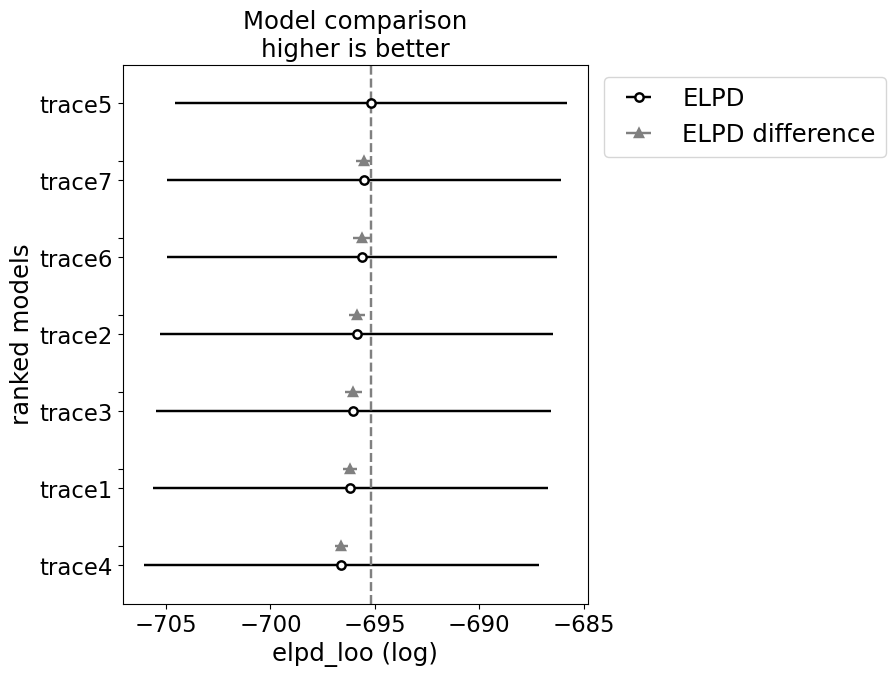

In [ ]:
az.plot_compare(df_comp_loo, insample_dev=False);

### Vergleiche nun den WAIC-Score der traces

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_waic (log)', ylabel='ranked models'>

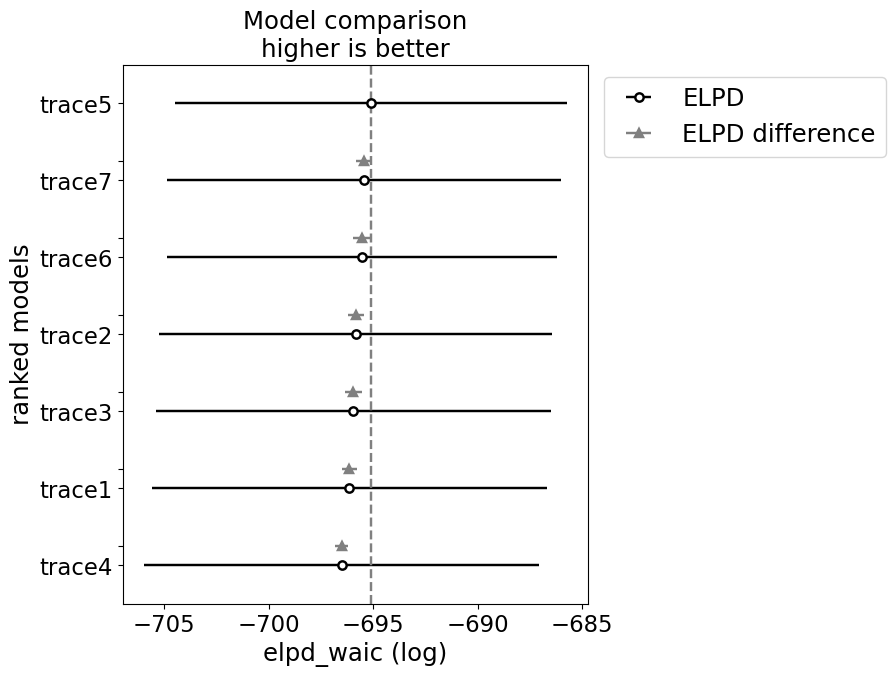

In [ ]:
traces = {"trace1": trace1, "trace2": trace2, "trace3": trace3, "trace4": trace4, "trace5": trace5, "trace6": trace6, "trace7": trace7}

waic_values = []

for trace_name, trace in traces.items():
    model = this_model
    waic = pm.waic(trace)
    waic_values.append(waic)
# Erstellen eines Dictionaries für den Vergleich
compare_dict = {f"{trace_name}": waic for trace_name, waic in zip(traces.keys(), waic_values)}

# Vergleichsobjekt erstellen
comp_waic = az.compare(compare_dict, ic="waic")

# Plot erstellen
az.plot_compare(comp_waic, insample_dev=False)

### Vergleiche nun die Pareto-K-Werte

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


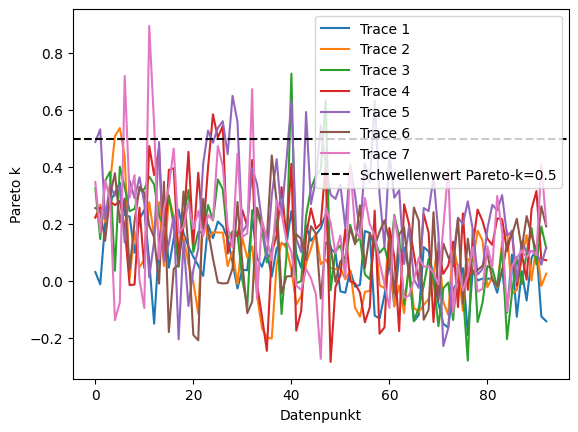

In [ ]:
# Extrahiere Pareto-k-Werte für alle Traces
pareto_k_values = [az.loo(trace, pointwise=True).pareto_k.values for trace in traces.values()]

# Konvertiere die Liste in ein numpy array
pareto_k_array = np.array(pareto_k_values)

# Eigener Plot erstellen
fig, ax = plt.subplots()

# Jeder Trace wird als eine eigene Linie dargestellt
for i, pareto_k in enumerate(pareto_k_array):
    ax.plot(pareto_k, label=f"Trace {i + 1}")

ax.set_xlabel("Datenpunkt")
ax.axhline(y=0.5, color='black', linestyle='--', label='Schwellenwert Pareto-k=0.5')
ax.set_ylabel("Pareto k")
ax.legend()

plt.show()


In [ ]:
# Schwellenwert für problematische Pareto-k-Werte
threshold = 0.5

# Zähle die Anzahl der problematischen Datenpunkte für jeden Trace
problematic_points_count = np.sum(pareto_k_array > threshold, axis=1)

# Zeige die Anzahl der problematischen Datenpunkte für jeden Trace an
for i, count in enumerate(problematic_points_count):
    print(f"Trace {i + 1}: {count} problematische Datenpunkte")

# Gesamtanzahl der Datenpunkte
total_data_points = pareto_k_array.shape[1]

# Berechne den Prozentsatz der problematischen Datenpunkte insgesamt
percentage_problematic = np.sum(problematic_points_count) / (len(traces) * total_data_points) * 100

print(f"Gesamter Prozentsatz der problematischen Datenpunkte: {percentage_problematic:.2f}%")

Trace 1: 0 problematische Datenpunkte
Trace 2: 2 problematische Datenpunkte
Trace 3: 2 problematische Datenpunkte
Trace 4: 3 problematische Datenpunkte
Trace 5: 10 problematische Datenpunkte
Trace 6: 0 problematische Datenpunkte
Trace 7: 4 problematische Datenpunkte
Gesamter Prozentsatz der problematischen Datenpunkte: 3.23%


### Vergleiche nun die RHat-Werte

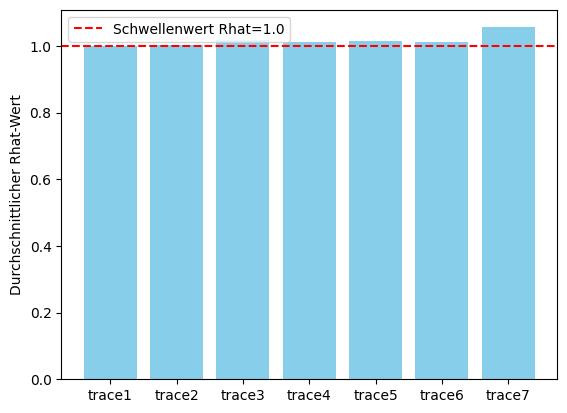

In [ ]:

traces = [trace1, trace2, trace3, trace4, trace5, trace6, trace7]

# Rhat-Werte für alle traces erhalten und den Durchschnitt berechnen
rhats = {f"trace{i+1}": az.summary(trace)["r_hat"].mean().item() for i, trace in enumerate(traces)}

# Visualisierung der Durchschnittlichen Rhat-Werte
fig, ax = plt.subplots()
ax.bar(rhats.keys(), rhats.values(), color='skyblue')
ax.axhline(y=1.0, color='red', linestyle='--', label='Schwellenwert Rhat=1.0')
ax.set_ylabel('Durchschnittlicher Rhat-Wert')
ax.legend()
plt.show()

In [1]:
import pandas as pd
def compare_traces(traces, execution_times):
    # Berechne den Normalized Mean Squared Error (NMSE) für jeden Trace
    with this_model:
      nmse_values = []
      for trace_name, trace in traces.items():
          predicted_cases = trace.posterior["new_cases"].mean(dim=("chain", "draw")).values[:len(new_cases_obs)]
          nmse = np.mean((observed_cases - predicted_cases)**2) / variance_observed
          nmse_values.append(nmse)


      # Berechne den LOO-Score für jeden Trace
      loo_values = [az.loo(trace) for trace in traces.values()]
      loo_elpd_values = [loo.loo_i.sum() for loo in loo_values]

      # Berechne den WAIC-Score für jeden Trace
      waic_values = [pm.waic(trace) for trace in traces.values()]
      waic_elpd_values = [waic.waic_i.sum() for waic in waic_values]
      # Berechne die Pareto-K-Werte für jeden Trace
      pareto_k_values = [az.loo(trace, pointwise=True).pareto_k.values for trace in traces.values()]

      # Berechne den Durchschnitt der Rhat-Werte für jeden Trace
      rhats = {f"{trace_name}": az.summary(trace)["r_hat"].mean().item() for trace_name, trace in traces.items()}

      # Füge die Ausführungszeiten hinzu
      execution_times_dict = {f"{trace_name}": exec_time for trace_name, exec_time in zip(traces.keys(), execution_times)}

      # Fasse alle Metriken in einem DataFrame zusammen
      metrics_df = pd.DataFrame({
          "NMSE": nmse_values,
          "LOO ELPD": loo_elpd_values,
          "WAIC ELPD": waic_elpd_values,
          "Rhat": rhats,
          "Execution Time": execution_times_dict,
      }, index=traces.keys())

      # Gewichte die Metriken (je niedriger, desto besser)
      weights = {
          "NMSE": 1,
          "LOO ELPD": -1,
          "WAIC ELPD": -1,
          "Rhat": 1,
          "Execution Time": 1,
      }

      weighted_metrics = metrics_df * weights

      # Berechne den Gesamtwert für jeden Trace
      total_values = weighted_metrics.sum(axis=1)

      # Finde den besten Trace (geringster Gesamtwert)
      best_trace_name = total_values.idxmin()

      return metrics_df, best_trace_name

In [ ]:
# Traces in einem Dictionary speichern
traces = {"trace1": trace1, "trace2": trace2, "trace3": trace3, "trace4": trace4, "trace5": trace5, "trace6": trace6, "trace7": trace7}
execution_times=[2926,1735,592,525,428,492,377]
# Funktion aufrufen
metrics_df, best_trace = compare_traces(traces, execution_times)

# Ausgabe anzeigen
print("Metriken für jeden Trace:")
print(metrics_df)
print("\nBester Trace:", best_trace)


/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the

Metriken für jeden Trace:
            NMSE                                           LOO ELPD  \
trace1  1.440265  <xarray.DataArray 'loo_i' ()>\narray(-695.9523...   
trace2  1.440996  <xarray.DataArray 'loo_i' ()>\narray(-695.9549...   
trace3  1.453841  <xarray.DataArray 'loo_i' ()>\narray(-696.4046...   
trace4  1.436889  <xarray.DataArray 'loo_i' ()>\narray(-695.8890...   
trace5  1.441595  <xarray.DataArray 'loo_i' ()>\narray(-695.2570...   
trace6  1.444795  <xarray.DataArray 'loo_i' ()>\narray(-695.6506...   
trace7  1.441095  <xarray.DataArray 'loo_i' ()>\narray(-695.4940...   

                                                WAIC ELPD      Rhat  \
trace1  <xarray.DataArray 'waic_i' ()>\narray(-695.908...  1.000684   
trace2  <xarray.DataArray 'waic_i' ()>\narray(-695.922...  1.000356   
trace3  <xarray.DataArray 'waic_i' ()>\narray(-696.333...  1.012619   
trace4  <xarray.DataArray 'waic_i' ()>\narray(-695.789...  1.009343   
trace5  <xarray.DataArray 'waic_i' ()>\narray(-695